In [1]:
%matplotlib inline

import cv2
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from loader import load_dataset, convert_to_one_hot, random_mini_batches, predict

In [2]:
# Data Paths

#full = 'data/dogsvcats.hdf5'
#X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, X_test_orig, Y_test_orig = load_dataset(full)

sample = 'data/dogsvcats-sample.hdf5'
X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, X_test_orig, Y_test_orig = load_dataset(sample)

y = 0


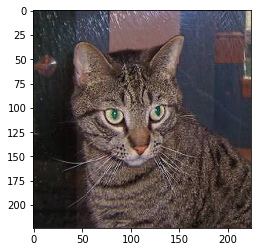

In [3]:
index = 3
plt.imshow(X_train_orig[index])
print("y = "+str(np.squeeze(Y_train_orig[:, index])))

y = 1


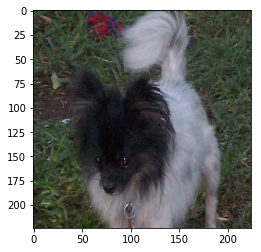

In [4]:
plt.imshow(X_val_orig[index])
print("y = "+str(np.squeeze(Y_val_orig[:,index])))

In [5]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_val_flatten = X_val_orig.reshape(X_val_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

X_train = X_train_flatten/255.
X_val = X_val_flatten/255.
X_test = X_test_flatten/255.

Y_train = convert_to_one_hot(Y_train_orig, 2)
Y_val = convert_to_one_hot(Y_val_orig, 2)
Y_test = convert_to_one_hot(Y_test_orig, 2)

print ("number of training examples = " + str(X_train.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("\nnumber of validation examples = " + str(X_val.shape[1]))
print ("X_val shape "+str(X_val.shape))
print ("Y_val shape"+str(Y_val.shape))
print ("\nnumber of test examples = " + str(X_test.shape[1]))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 60
X_train shape: (150528, 60)
Y_train shape: (2, 60)

number of validation examples = 20
X_val shape (150528, 20)
Y_val shape(2, 20)

number of test examples = 20
X_test shape: (150528, 20)
Y_test shape: (2, 20)


In [6]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 224 * 224 * 3 = 150528)
    n_y -- scalar, number of classes (from 0 to 1, so -> 2)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###
    
    return X, Y

In [7]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [50, 150528]
                        b1 : [50, 1]
                        W2 : [25, 50]
                        b2 : [25, 1]
                        W3 : [2, 25]
                        b3 : [2, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    
    """
    W1 = tf.get_variable("W1", [50, 150528], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [50, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [25, 50], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [25, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [8]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)                     
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3

In [9]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (2, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [10]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    seed = 3
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Val Accuracy:", accuracy.eval({X: X_val, Y: Y_val}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [11]:
parameters = model(X_train, Y_train, X_test, Y_test)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

[[ 0.56470588  0.88235294  1.         ...,  0.02352941  0.58431373
   0.38823529]
 [ 0.57647059  0.21568627  1.         ...,  0.02352941  0.4627451
   0.39607843]
 [ 0.60392157  0.35686275  1.         ...,  0.02352941  0.41960784
   0.38431373]
 ..., 
 [ 0.93333333  0.83529412  1.         ...,  0.05490196  0.74901961
   0.54509804]
 [ 0.94117647  0.08627451  1.         ...,  0.05490196  0.83529412
   0.55294118]
 [ 0.9372549   0.20392157  1.         ...,  0.05490196  1.          0.54117647]]
Cost after epoch 0: 1.680811
[[ 0.9254902   0.96078431  0.7372549  ...,  0.04705882  0.22745098
   0.01176471]
 [ 0.58823529  0.93333333  0.56862745 ...,  0.04705882  0.21960784
   0.01568627]
 [ 0.58431373  0.82352941  0.35294118 ...,  0.04705882  0.03529412
   0.03529412]
 ..., 
 [ 0.92156863  0.38823529  0.462

[[ 0.56470588  0.50980392  0.49019608 ...,  0.01568627  0.01568627
   0.01176471]
 [ 0.57647059  0.41960784  0.58823529 ...,  0.01960784  0.01568627
   0.01568627]
 [ 0.60392157  0.34901961  0.61568627 ...,  0.          0.01568627
   0.03529412]
 ..., 
 [ 0.93333333  0.2745098   0.38823529 ...,  0.81176471  0.30588235
   0.34509804]
 [ 0.94117647  0.25882353  0.34509804 ...,  0.82352941  0.20784314
   0.42745098]
 [ 0.9372549   0.22352941  0.32941176 ...,  0.39215686  0.09019608
   0.28235294]]
[[ 0.50980392  0.11372549  0.49019608 ...,  1.          0.01568627
   0.13333333]
 [ 0.41960784  0.08627451  0.58823529 ...,  1.          0.01960784
   0.11372549]
 [ 0.34901961  0.0745098   0.61568627 ...,  1.          0.          0.09019608]
 ..., 
 [ 0.2745098   0.56470588  0.38823529 ...,  1.          0.81176471
   0.34509804]
 [ 0.25882353  0.54117647  0.34509804 ...,  1.          0.82352941
   0.34509804]
 [ 0.22352941  0.49411765  0.32941176 ...,  1.          0.39215686
   0.09411765]]
[[

[[ 0.13333333  0.02352941  0.96862745 ...,  0.28235294  0.90588235
   0.01568627]
 [ 0.11372549  0.02352941  0.97647059 ...,  0.28627451  0.89019608
   0.01960784]
 [ 0.09019608  0.02352941  0.82352941 ...,  0.23529412  0.88235294  0.        ]
 ..., 
 [ 0.34509804  0.05490196  0.69019608 ...,  1.          0.94509804
   0.81176471]
 [ 0.34509804  0.05490196  0.76862745 ...,  1.          0.95686275
   0.82352941]
 [ 0.09411765  0.05490196  0.39607843 ...,  1.          0.95686275
   0.39215686]]
[[ 0.62352941  0.89803922  0.49019608 ...,  0.28235294  0.48235294
   0.89803922]
 [ 0.58431373  0.8627451   0.58823529 ...,  0.29019608  0.49803922
   0.85098039]
 [ 0.54509804  0.86666667  0.61568627 ...,  0.3372549   0.43137255  0.8       ]
 ..., 
 [ 0.46666667  0.20784314  0.38823529 ...,  0.69803922  0.43921569
   0.96470588]
 [ 0.44705882  0.20392157  0.34509804 ...,  0.57647059  0.41960784
   0.96862745]
 [ 0.36862745  0.19607843  0.32941176 ...,  0.39215686  0.39607843
   0.91372549]]
[[ 0

[[ 0.28235294  0.54901961  0.79607843 ...,  0.08627451  0.26666667
   0.04705882]
 [ 0.29019608  0.68627451  0.64313725 ...,  0.37647059  0.23921569
   0.04705882]
 [ 0.3372549   0.12941176  0.34117647 ...,  0.86666667  0.27058824
   0.04705882]
 ..., 
 [ 0.69803922  0.42352941  0.00392157 ...,  0.17254902  0.25098039
   0.0745098 ]
 [ 0.57647059  0.52941176  0.00392157 ...,  0.57647059  0.35294118
   0.0745098 ]
 [ 0.39215686  0.10980392  0.         ...,  0.98823529  0.41960784
   0.0627451 ]]
[[ 0.56862745  0.62352941  0.01568627 ...,  0.47843137  0.01568627
   0.96862745]
 [ 0.47843137  0.58431373  0.01960784 ...,  0.48235294  0.01568627
   0.97647059]
 [ 0.2627451   0.54509804  0.         ...,  0.4627451   0.01568627
   0.82352941]
 ..., 
 [ 0.39607843  0.46666667  0.81176471 ...,  0.51372549  0.30588235
   0.69019608]
 [ 0.37254902  0.44705882  0.82352941 ...,  0.49803922  0.20784314
   0.76862745]
 [ 0.3254902   0.36862745  0.39215686 ...,  0.45098039  0.09019608
   0.39607843]]


 [ 0.24705882  0.63529412  0.05490196 ...,  0.          1.          0.38823529]]
[[ 0.3254902   0.26666667  0.58431373 ...,  0.48235294  0.57647059
   0.90588235]
 [ 0.36470588  0.39215686  0.4627451  ...,  0.49803922  0.57647059
   0.89019608]
 [ 0.41176471  0.08235294  0.41960784 ...,  0.43137255  0.57647059
   0.88235294]
 ..., 
 [ 0.73333333  0.2627451   0.74901961 ...,  0.43921569  0.20784314
   0.94509804]
 [ 0.78823529  0.20392157  0.83529412 ...,  0.41960784  0.25098039
   0.95686275]
 [ 0.8         0.23137255  1.         ...,  0.39607843  0.23529412
   0.95686275]]
[[ 0.48235294  0.96862745  0.56470588 ...,  0.58431373  0.56470588
   0.24313725]
 [ 0.49803922  0.97647059  0.57647059 ...,  0.4627451   0.58039216
   0.24313725]
 [ 0.43137255  0.82352941  0.60392157 ...,  0.41960784  0.5372549
   0.24313725]
 ..., 
 [ 0.43921569  0.69019608  0.93333333 ...,  0.74901961  0.88235294
   0.67843137]
 [ 0.41960784  0.76862745  0.94117647 ...,  0.83529412  0.80784314
   0.65882353]
 [ 

[[ 0.96078431  0.88235294  0.62352941 ...,  0.56470588  0.04313725
   0.56470588]
 [ 0.93333333  0.21568627  0.58431373 ...,  0.57647059  0.02352941
   0.58039216]
 [ 0.82352941  0.35686275  0.54509804 ...,  0.60392157  0.01176471
   0.5372549 ]
 ..., 
 [ 0.38823529  0.83529412  0.46666667 ...,  0.93333333  0.17254902
   0.88235294]
 [ 0.2745098   0.08627451  0.44705882 ...,  0.94117647  0.18823529
   0.80784314]
 [ 0.17254902  0.20392157  0.36862745 ...,  0.9372549   0.2627451
   0.65098039]]
[[ 0.54901961  0.7372549   0.04705882 ...,  0.79607843  0.86666667
   0.81960784]
 [ 0.68627451  0.56862745  0.04705882 ...,  0.64313725  0.7372549
   0.96470588]
 [ 0.12941176  0.35294118  0.04705882 ...,  0.34117647  0.6627451
   0.99607843]
 ..., 
 [ 0.42352941  0.4627451   0.0745098  ...,  0.00392157  0.25882353
   0.21568627]
 [ 0.52941176  0.34901961  0.0745098  ...,  0.00392157  0.17254902
   0.29411765]
 [ 0.10980392  0.19215686  0.0627451  ...,  0.          0.12941176
   0.09019608]]
[[ 

 [ 1.          0.1254902   0.9372549  ...,  0.45098039  0.09019608  1.        ]]
[[ 0.40392157  0.86666667  0.04705882 ...,  0.3254902   0.26666667
   0.04313725]
 [ 0.4         0.7372549   0.04705882 ...,  0.36470588  0.39215686
   0.04313725]
 [ 0.42352941  0.6627451   0.04705882 ...,  0.41176471  0.08235294
   0.02745098]
 ..., 
 [ 0.94509804  0.25882353  0.0745098  ...,  0.73333333  0.2627451
   0.49411765]
 [ 0.96470588  0.17254902  0.0745098  ...,  0.78823529  0.20392157
   0.43137255]
 [ 0.94901961  0.12941176  0.0627451  ...,  0.8         0.23137255
   0.38039216]]
[[ 0.56470588  0.60784314  0.96862745 ...,  0.49019608  0.50980392
   0.01176471]
 [ 0.58039216  0.47058824  0.97647059 ...,  0.58823529  0.41960784
   0.01568627]
 [ 0.5372549   0.39607843  0.82352941 ...,  0.61568627  0.34901961
   0.03529412]
 ..., 
 [ 0.88235294  0.23137255  0.69019608 ...,  0.38823529  0.2745098
   0.34509804]
 [ 0.80784314  0.15686275  0.76862745 ...,  0.34509804  0.25882353
   0.42745098]
 [ 0

[[ 0.64705882  0.71764706  0.89803922 ...,  0.50980392  0.7372549
   0.86666667]
 [ 0.53333333  0.58823529  0.8627451  ...,  0.41960784  0.56862745
   0.7372549 ]
 [ 0.41568627  0.52156863  0.86666667 ...,  0.34901961  0.35294118
   0.6627451 ]
 ..., 
 [ 0.78039216  0.81568627  0.20784314 ...,  0.2745098   0.4627451
   0.25882353]
 [ 0.72941176  0.80392157  0.20392157 ...,  0.25882353  0.34901961
   0.17254902]
 [ 0.6627451   0.84705882  0.19607843 ...,  0.22352941  0.19215686
   0.12941176]]
[[ 0.9254902   0.26666667  0.08627451 ...,  0.0627451   0.04705882
   0.99607843]
 [ 0.58823529  0.39215686  0.37647059 ...,  0.08235294  0.04705882  1.        ]
 [ 0.58431373  0.08235294  0.86666667 ...,  0.10588235  0.04705882
   0.99215686]
 ..., 
 [ 0.92156863  0.2627451   0.17254902 ...,  0.17647059  0.0745098
   0.31764706]
 [ 0.57647059  0.20392157  0.57647059 ...,  0.23921569  0.0745098
   0.35686275]
 [ 0.29411765  0.23137255  0.98823529 ...,  0.37647059  0.0627451
   0.40392157]]
[[ 0.01

[[ 0.92156863  0.56862745  0.75294118 ...,  0.49019608  0.26666667
   0.22745098]
 [ 0.91764706  0.47843137  0.65098039 ...,  0.58823529  0.39215686
   0.21960784]
 [ 0.97254902  0.2627451   0.52156863 ...,  0.61568627  0.08235294
   0.03529412]
 ..., 
 [ 0.70588235  0.39607843  0.43529412 ...,  0.38823529  0.2627451
   0.09803922]
 [ 0.65098039  0.37254902  0.31372549 ...,  0.34509804  0.20392157
   0.61568627]
 [ 0.61568627  0.3254902   0.19215686 ...,  0.32941176  0.23137255
   0.38823529]]
[[ 0.01568627  0.56470588  0.60784314 ...,  0.24313725  0.38823529
   0.47843137]
 [ 0.01960784  0.58039216  0.47058824 ...,  0.24313725  0.39607843
   0.48235294]
 [ 0.          0.5372549   0.39607843 ...,  0.24313725  0.38431373
   0.4627451 ]
 ..., 
 [ 0.81176471  0.88235294  0.23137255 ...,  0.67843137  0.54509804
   0.51372549]
 [ 0.82352941  0.80784314  0.15686275 ...,  0.65882353  0.55294118
   0.49803922]
 [ 0.39215686  0.65098039  0.1254902  ...,  0.64705882  0.54117647
   0.45098039]]
[

[[ 0.81960784  0.62352941  0.56470588 ...,  0.11372549  0.48235294
   0.22745098]
 [ 0.96470588  0.58431373  0.58039216 ...,  0.08627451  0.49803922
   0.21960784]
 [ 0.99607843  0.54509804  0.5372549  ...,  0.0745098   0.43137255
   0.03529412]
 ..., 
 [ 0.21568627  0.46666667  0.88235294 ...,  0.56470588  0.43921569
   0.09803922]
 [ 0.29411765  0.44705882  0.80784314 ...,  0.54117647  0.41960784
   0.61568627]
 [ 0.09019608  0.36862745  0.65098039 ...,  0.49411765  0.39607843
   0.38823529]]
[[ 0.24313725  0.26666667  0.96862745 ...,  0.79607843  0.48235294
   0.40392157]
 [ 0.24313725  0.23921569  0.97647059 ...,  0.64313725  0.49803922  0.4       ]
 [ 0.24313725  0.27058824  0.82352941 ...,  0.34117647  0.43137255
   0.42352941]
 ..., 
 [ 0.67843137  0.25098039  0.69019608 ...,  0.00392157  0.43921569
   0.94509804]
 [ 0.65882353  0.35294118  0.76862745 ...,  0.00392157  0.41960784
   0.96470588]
 [ 0.64705882  0.41960784  0.39607843 ...,  0.          0.39607843
   0.94901961]]
[[

[[ 0.60784314  0.62352941  0.58431373 ...,  0.50980392  0.11372549
   0.26666667]
 [ 0.47058824  0.58431373  0.4627451  ...,  0.41960784  0.08627451
   0.39215686]
 [ 0.39607843  0.54509804  0.41960784 ...,  0.34901961  0.0745098
   0.08235294]
 ..., 
 [ 0.23137255  0.46666667  0.74901961 ...,  0.2745098   0.56470588
   0.2627451 ]
 [ 0.15686275  0.44705882  0.83529412 ...,  0.25882353  0.54117647
   0.20392157]
 [ 0.1254902   0.36862745  1.         ...,  0.22352941  0.49411765
   0.23137255]]
[[ 0.64705882  0.89803922  0.32941176 ...,  0.48235294  0.84705882
   0.54901961]
 [ 0.53333333  0.8627451   0.31372549 ...,  0.49803922  0.78039216
   0.68627451]
 [ 0.41568627  0.86666667  0.23529412 ...,  0.43137255  0.98431373
   0.12941176]
 ..., 
 [ 0.78039216  0.20784314  0.45098039 ...,  0.43921569  0.98431373
   0.42352941]
 [ 0.72941176  0.20392157  0.4        ...,  0.41960784  0.99215686
   0.52941176]
 [ 0.6627451   0.19607843  0.33333333 ...,  0.39607843  1.          0.10980392]]
[[ 

[[ 0.56862745  0.75294118  0.90588235 ...,  0.00784314  0.56470588
   0.49019608]
 [ 0.47843137  0.65098039  0.89019608 ...,  0.00784314  0.58039216
   0.58823529]
 [ 0.2627451   0.52156863  0.88235294 ...,  0.00784314  0.5372549
   0.61568627]
 ..., 
 [ 0.39607843  0.43529412  0.94509804 ...,  0.24313725  0.88235294
   0.38823529]
 [ 0.37254902  0.31372549  0.95686275 ...,  0.27843137  0.80784314
   0.34509804]
 [ 0.3254902   0.19215686  0.95686275 ...,  0.26666667  0.65098039
   0.32941176]]
[[ 0.54901961  0.49019608  0.62352941 ...,  0.0627451   0.34117647
   0.56862745]
 [ 0.68627451  0.58823529  0.58431373 ...,  0.08235294  0.41568627
   0.47843137]
 [ 0.12941176  0.61568627  0.54509804 ...,  0.10588235  0.61568627
   0.2745098 ]
 ..., 
 [ 0.42352941  0.38823529  0.46666667 ...,  0.17647059  1.          0.77254902]
 [ 0.52941176  0.34509804  0.44705882 ...,  0.23921569  1.          0.56470588]
 [ 0.10980392  0.32941176  0.36862745 ...,  0.37647059  1.          0.63529412]]
[[ 0.75

[[ 0.96862745  0.81960784  0.48235294 ...,  0.89803922  0.32941176
   0.28235294]
 [ 0.97647059  0.96470588  0.21568627 ...,  0.85098039  0.31372549
   0.29019608]
 [ 0.82352941  0.99607843  0.21176471 ...,  0.8         0.23529412
   0.3372549 ]
 ..., 
 [ 0.69019608  0.21568627  0.78823529 ...,  0.96470588  0.45098039
   0.69803922]
 [ 0.76862745  0.29411765  0.56862745 ...,  0.96862745  0.4         0.57647059]
 [ 0.39607843  0.09019608  0.57254902 ...,  0.91372549  0.33333333
   0.39215686]]
[[ 0.15294118  0.13333333  0.92156863 ...,  0.56470588  0.01568627
   0.3254902 ]
 [ 0.17254902  0.11372549  0.91764706 ...,  0.57647059  0.01568627
   0.36470588]
 [ 0.15686275  0.09019608  0.97254902 ...,  0.60392157  0.01568627
   0.41176471]
 ..., 
 [ 0.16470588  0.34509804  0.70588235 ...,  0.93333333  0.30588235
   0.73333333]
 [ 0.12156863  0.34509804  0.65098039 ...,  0.94117647  0.20784314
   0.78823529]
 [ 0.09019608  0.09411765  0.61568627 ...,  0.9372549   0.09019608  0.8       ]]
[[ 0

[[ 0.96862745  0.56862745  0.50196078 ...,  0.04313725  0.26666667
   0.02352941]
 [ 0.97647059  0.47843137  0.4745098  ...,  0.02352941  0.23921569
   0.02352941]
 [ 0.82352941  0.2627451   0.19215686 ...,  0.01176471  0.27058824
   0.02352941]
 ..., 
 [ 0.69019608  0.39607843  0.20392157 ...,  0.17254902  0.25098039
   0.05490196]
 [ 0.76862745  0.37254902  0.19215686 ...,  0.18823529  0.35294118
   0.05490196]
 [ 0.39607843  0.3254902   0.11764706 ...,  0.2627451   0.41960784
   0.05490196]]
[[ 0.0627451   0.13333333  0.84705882 ...,  0.71764706  0.40392157
   0.47843137]
 [ 0.08235294  0.11372549  0.78039216 ...,  0.58823529  0.4         0.48235294]
 [ 0.10588235  0.09019608  0.98431373 ...,  0.52156863  0.42352941
   0.4627451 ]
 ..., 
 [ 0.17647059  0.34509804  0.98431373 ...,  0.81568627  0.94509804
   0.51372549]
 [ 0.23921569  0.34509804  0.99215686 ...,  0.80392157  0.96470588
   0.49803922]
 [ 0.37647059  0.09411765  1.         ...,  0.84705882  0.94901961
   0.45098039]]
[[

[[ 0.50980392  1.          0.15294118 ...,  0.81960784  0.9254902
   0.50196078]
 [ 0.41960784  1.          0.17254902 ...,  0.96470588  0.58823529
   0.4745098 ]
 [ 0.34901961  1.          0.15686275 ...,  0.99607843  0.58431373
   0.19215686]
 ..., 
 [ 0.2745098   1.          0.16470588 ...,  0.21568627  0.92156863
   0.20392157]
 [ 0.25882353  1.          0.12156863 ...,  0.29411765  0.57647059
   0.19215686]
 [ 0.22352941  1.          0.09019608 ...,  0.09019608  0.29411765
   0.11764706]]
[[ 0.38823529  0.01568627  0.28235294 ...,  0.01568627  0.96862745
   0.58431373]
 [ 0.39607843  0.01960784  0.28627451 ...,  0.01568627  0.97647059
   0.4627451 ]
 [ 0.38431373  0.          0.23529412 ...,  0.01568627  0.82352941
   0.41960784]
 ..., 
 [ 0.54509804  0.81176471  1.         ...,  0.30588235  0.69019608
   0.74901961]
 [ 0.55294118  0.82352941  1.         ...,  0.20784314  0.76862745
   0.83529412]
 [ 0.54117647  0.39215686  1.         ...,  0.09019608  0.39607843  1.        ]]
[[ 

[[ 0.68627451  0.50196078  0.56862745 ...,  0.38823529  0.48235294
   0.13333333]
 [ 0.54509804  0.4745098   0.47843137 ...,  0.39607843  0.21568627
   0.11372549]
 [ 0.41960784  0.19215686  0.2627451  ...,  0.38431373  0.21176471
   0.09019608]
 ..., 
 [ 0.64705882  0.20392157  0.39607843 ...,  0.54509804  0.78823529
   0.34509804]
 [ 0.44313725  0.19215686  0.37254902 ...,  0.55294118  0.56862745
   0.34509804]
 [ 0.24705882  0.11764706  0.3254902  ...,  0.54117647  0.57254902
   0.09411765]]
[[ 0.26666667  0.96078431  0.50196078 ...,  0.02352941  0.13333333
   0.04705882]
 [ 0.39215686  0.93333333  0.4745098  ...,  0.02352941  0.11372549
   0.04705882]
 [ 0.08235294  0.82352941  0.19215686 ...,  0.02352941  0.09019608
   0.04705882]
 ..., 
 [ 0.2627451   0.38823529  0.20392157 ...,  0.05490196  0.34509804
   0.0745098 ]
 [ 0.20392157  0.2745098   0.19215686 ...,  0.05490196  0.34509804
   0.0745098 ]
 [ 0.23137255  0.17254902  0.11764706 ...,  0.05490196  0.09411765
   0.0627451 ]]


[[ 0.9254902   0.28235294  0.01176471 ...,  0.89803922  0.58431373
   0.89803922]
 [ 0.58823529  0.28627451  0.01568627 ...,  0.8627451   0.4627451
   0.85098039]
 [ 0.58431373  0.23529412  0.03529412 ...,  0.86666667  0.41960784  0.8       ]
 ..., 
 [ 0.92156863  1.          0.34509804 ...,  0.20784314  0.74901961
   0.96470588]
 [ 0.57647059  1.          0.42745098 ...,  0.20392157  0.83529412
   0.96862745]
 [ 0.29411765  1.          0.28235294 ...,  0.19607843  1.          0.91372549]]
[[ 0.32941176  0.24313725  0.88235294 ...,  0.68627451  0.01568627
   0.96862745]
 [ 0.31372549  0.24313725  0.21568627 ...,  0.54509804  0.01960784
   0.97647059]
 [ 0.23529412  0.24313725  0.35686275 ...,  0.41960784  0.          0.82352941]
 ..., 
 [ 0.45098039  0.67843137  0.83529412 ...,  0.64705882  0.81176471
   0.69019608]
 [ 0.4         0.65882353  0.08627451 ...,  0.44313725  0.82352941
   0.76862745]
 [ 0.33333333  0.64705882  0.20392157 ...,  0.24705882  0.39215686
   0.39607843]]
[[ 0.45

[[ 0.56470588  0.96862745  0.56470588 ...,  0.32941176  0.34509804
   0.40392157]
 [ 0.57647059  0.97647059  0.58039216 ...,  0.31372549  0.42352941  0.4       ]
 [ 0.60392157  0.82352941  0.5372549  ...,  0.23529412  0.30196078
   0.42352941]
 ..., 
 [ 0.93333333  0.69019608  0.88235294 ...,  0.45098039  0.03921569
   0.94509804]
 [ 0.94117647  0.76862745  0.80784314 ...,  0.4         0.10980392
   0.96470588]
 [ 0.9372549   0.39607843  0.65098039 ...,  0.33333333  0.01176471
   0.94901961]]
[[ 0.48235294  0.34509804  0.56862745 ...,  0.49019608  0.0627451
   0.9254902 ]
 [ 0.49803922  0.42352941  0.47843137 ...,  0.58823529  0.08235294
   0.58823529]
 [ 0.43137255  0.30196078  0.2627451  ...,  0.61568627  0.10588235
   0.58431373]
 ..., 
 [ 0.43921569  0.03921569  0.39607843 ...,  0.38823529  0.17647059
   0.92156863]
 [ 0.41960784  0.10980392  0.37254902 ...,  0.34509804  0.23921569
   0.57647059]
 [ 0.39607843  0.01176471  0.3254902  ...,  0.32941176  0.37647059
   0.29411765]]
Cos

[[ 0.57647059  0.04705882  0.3254902  ...,  0.9254902   0.01568627
   0.48235294]
 [ 0.57647059  0.04705882  0.36470588 ...,  0.58823529  0.01568627
   0.21568627]
 [ 0.57647059  0.04705882  0.41176471 ...,  0.58431373  0.01568627
   0.21176471]
 ..., 
 [ 0.20784314  0.0745098   0.73333333 ...,  0.92156863  0.30588235
   0.78823529]
 [ 0.25098039  0.0745098   0.78823529 ...,  0.57647059  0.20784314
   0.56862745]
 [ 0.23529412  0.0627451   0.8        ...,  0.29411765  0.09019608
   0.57254902]]
[[ 0.04313725  0.68627451  0.24313725 ...,  0.71764706  0.13333333
   0.62352941]
 [ 0.04313725  0.54509804  0.24313725 ...,  0.58823529  0.11372549
   0.58431373]
 [ 0.02745098  0.41960784  0.24313725 ...,  0.52156863  0.09019608
   0.54509804]
 ..., 
 [ 0.49411765  0.64705882  0.67843137 ...,  0.81568627  0.34509804
   0.46666667]
 [ 0.43137255  0.44313725  0.65882353 ...,  0.80392157  0.34509804
   0.44705882]
 [ 0.38039216  0.24705882  0.64705882 ...,  0.84705882  0.09411765
   0.36862745]]


[[ 0.28235294  0.56470588  0.50196078 ...,  0.22745098  0.56862745
   0.64705882]
 [ 0.29019608  0.57647059  0.4745098  ...,  0.21960784  0.47843137
   0.53333333]
 [ 0.3372549   0.60392157  0.19215686 ...,  0.03529412  0.2745098
   0.41568627]
 ..., 
 [ 0.69803922  0.93333333  0.20392157 ...,  0.09803922  0.77254902
   0.78039216]
 [ 0.57647059  0.94117647  0.19215686 ...,  0.61568627  0.56470588
   0.72941176]
 [ 0.39215686  0.9372549   0.11764706 ...,  0.38823529  0.63529412
   0.6627451 ]]
[[ 0.90588235  0.11372549  0.86666667 ...,  0.7372549   0.26666667
   0.56470588]
 [ 0.89019608  0.08627451  0.7372549  ...,  0.56862745  0.39215686
   0.57647059]
 [ 0.88235294  0.0745098   0.6627451  ...,  0.35294118  0.08235294
   0.60392157]
 ..., 
 [ 0.94509804  0.56470588  0.25882353 ...,  0.4627451   0.2627451
   0.93333333]
 [ 0.95686275  0.54117647  0.17254902 ...,  0.34901961  0.20392157
   0.94117647]
 [ 0.95686275  0.49411765  0.12941176 ...,  0.19215686  0.23137255
   0.9372549 ]]
[[

   0.98823529]]
[[ 0.0627451   0.79607843  0.89803922 ...,  0.75294118  0.24313725
   0.50980392]
 [ 0.08235294  0.64313725  0.85098039 ...,  0.65098039  0.24313725
   0.41960784]
 [ 0.10588235  0.34117647  0.8        ...,  0.52156863  0.24313725
   0.34901961]
 ..., 
 [ 0.17647059  0.00392157  0.96470588 ...,  0.43529412  0.67843137
   0.2745098 ]
 [ 0.23921569  0.00392157  0.96862745 ...,  0.31372549  0.65882353
   0.25882353]
 [ 0.37647059  0.          0.91372549 ...,  0.19215686  0.64705882
   0.22352941]]
[[ 0.01568627  0.24313725  0.40392157 ...,  0.71764706  0.92156863
   0.60784314]
 [ 0.01960784  0.24313725  0.4        ...,  0.58823529  0.91764706
   0.47058824]
 [ 0.          0.24313725  0.42352941 ...,  0.52156863  0.97254902
   0.39607843]
 ..., 
 [ 0.81176471  0.67843137  0.94509804 ...,  0.81568627  0.70588235
   0.23137255]
 [ 0.82352941  0.65882353  0.96470588 ...,  0.80392157  0.65098039
   0.15686275]
 [ 0.39215686  0.64705882  0.94901961 ...,  0.84705882  0.61568627


[[ 0.45882353  0.56470588  0.58431373 ...,  0.47843137  0.40392157
   0.9254902 ]
 [ 0.45098039  0.57647059  0.4627451  ...,  0.48235294  0.4         0.58823529]
 [ 0.49411765  0.60392157  0.41960784 ...,  0.4627451   0.42352941
   0.58431373]
 ..., 
 [ 0.25098039  0.93333333  0.74901961 ...,  0.51372549  0.94509804
   0.92156863]
 [ 0.29019608  0.94117647  0.83529412 ...,  0.49803922  0.96470588
   0.57647059]
 [ 0.29803922  0.9372549   1.         ...,  0.45098039  0.94901961
   0.29411765]]
[[ 0.48235294  0.56470588  0.22745098 ...,  0.7372549   0.24313725
   0.01176471]
 [ 0.21568627  0.58039216  0.21960784 ...,  0.56862745  0.24313725
   0.01568627]
 [ 0.21176471  0.5372549   0.03529412 ...,  0.35294118  0.24313725
   0.03529412]
 ..., 
 [ 0.78823529  0.88235294  0.09803922 ...,  0.4627451   0.67843137
   0.34509804]
 [ 0.56862745  0.80784314  0.61568627 ...,  0.34901961  0.65882353
   0.42745098]
 [ 0.57254902  0.65098039  0.38823529 ...,  0.19215686  0.64705882
   0.28235294]]
[[

[[ 0.99607843  0.71764706  0.47843137 ...,  0.92156863  0.48235294
   0.56862745]
 [ 1.          0.58823529  0.48235294 ...,  0.91764706  0.49803922
   0.47843137]
 [ 0.99215686  0.52156863  0.4627451  ...,  0.97254902  0.43137255
   0.2627451 ]
 ..., 
 [ 0.31764706  0.81568627  0.51372549 ...,  0.70588235  0.43921569
   0.39607843]
 [ 0.35686275  0.80392157  0.49803922 ...,  0.65098039  0.41960784
   0.37254902]
 [ 0.40392157  0.84705882  0.45098039 ...,  0.61568627  0.39607843
   0.3254902 ]]
[[ 0.38823529  0.49019608  0.9254902  ...,  0.71764706  0.60784314
   0.02352941]
 [ 0.39607843  0.58823529  0.58823529 ...,  0.58823529  0.47058824
   0.02352941]
 [ 0.38431373  0.61568627  0.58431373 ...,  0.52156863  0.39607843
   0.02352941]
 ..., 
 [ 0.54509804  0.38823529  0.92156863 ...,  0.81568627  0.23137255
   0.05490196]
 [ 0.55294118  0.34509804  0.57647059 ...,  0.80392157  0.15686275
   0.05490196]
 [ 0.54117647  0.32941176  0.29411765 ...,  0.84705882  0.1254902
   0.05490196]]
[

[[ 0.90588235  0.50196078  0.34509804 ...,  0.7372549   0.38823529
   0.58431373]
 [ 0.89019608  0.4745098   0.42352941 ...,  0.56862745  0.39607843
   0.4627451 ]
 [ 0.88235294  0.19215686  0.30196078 ...,  0.35294118  0.38431373
   0.41960784]
 ..., 
 [ 0.94509804  0.20392157  0.03921569 ...,  0.4627451   0.54509804
   0.74901961]
 [ 0.95686275  0.19215686  0.10980392 ...,  0.34901961  0.55294118
   0.83529412]
 [ 0.95686275  0.11764706  0.01176471 ...,  0.19215686  0.54117647  1.        ]]
[[ 0.64705882  0.34117647  0.50980392 ...,  0.04705882  0.45882353
   0.56862745]
 [ 0.53333333  0.41568627  0.41960784 ...,  0.04705882  0.45098039
   0.47843137]
 [ 0.41568627  0.61568627  0.34901961 ...,  0.04705882  0.49411765
   0.2627451 ]
 ..., 
 [ 0.78039216  1.          0.2745098  ...,  0.0745098   0.25098039
   0.39607843]
 [ 0.72941176  1.          0.25882353 ...,  0.0745098   0.29019608
   0.37254902]
 [ 0.6627451   1.          0.22352941 ...,  0.0627451   0.29803922
   0.3254902 ]]


KeyboardInterrupt: 

In [ ]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = "sample.jpg"

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(224, 224)).reshape((1, 224 * 224 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))